# Data Visualization

## Specifications

This workflow should produce three publication-quality visualizations:

1. Daily-mean radiative fluxes at top of atmosphere and surface from ERA5 for 22 September 2020.
2. Intrinsic atmospheric radiative properties (reflectivity, absorptivity, and transmissivity) based on the Stephens et al. (2015) model.
3. Potential surface-reflected outgoing solar radiation, actual surface-reflected outgoing solar radiation, and their difference (gain).

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
from utils import check_environment

check_environment("visualize")

import logging
import os
from sys import platform

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from google.cloud import storage
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import multiprocessing
import numpy as np
import xarray as xr

### Setup

In [2]:
data_dir = "../assets"

# Xarray configuration
xr.set_options(keep_attrs=True)

# Multiprocessing configuration for MacOS
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396

# Logging configuration
logging.basicConfig(filename="visualize.log", filemode="w", level=logging.INFO)

## Functions

In [14]:
def get_data_gcs(bucket_name, file_name, file_path="."):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        bucket_name: Google Cloud Storage bucket to download from.
        file_name: name of file to download from gcs.
        file_path: path to place file locally.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(file_name)
    blob.download_to_filename(filename=os.path.join(file_path, file_name))
    

def plot_geodata(ax, lats, lons, data, levels, vmax, cmap, title):
    """Visualize geographic data."""
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax.contourf(lons, lats, data, levels, vmin=0, vmax=vmax, 
                cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_title(title)
    ax.coastlines("50m", linewidth=0.75)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

## Workflow

### Download Data from GCS

In [4]:
#get_data_gcs("era5-single-level-daily", "20200922.nc", data_dir)

In [5]:
#get_data_gcs("rom-input", "rom_analysis.nc", data_dir)

### Figure 1: Boundary Fluxes

1. Top of atmosphere incoming solar radiation
1. Surface downwelling solar radiation
1. Surface upwelling solar radiation
1. Top of atmosphere outgoing solar radiation

In [6]:
era5_daily = xr.open_dataset(os.path.join(data_dir, "20200922.nc"))

lons = era5_daily.longitude.data
lats = era5_daily.latitude.data
tisr = era5_daily.tisr.isel(time=0).data
ssrd = era5_daily.ssrd.isel(time=0).data
tosr = era5_daily.tosr.isel(time=0).data
ssru = era5_daily.ssru.isel(time=0).data

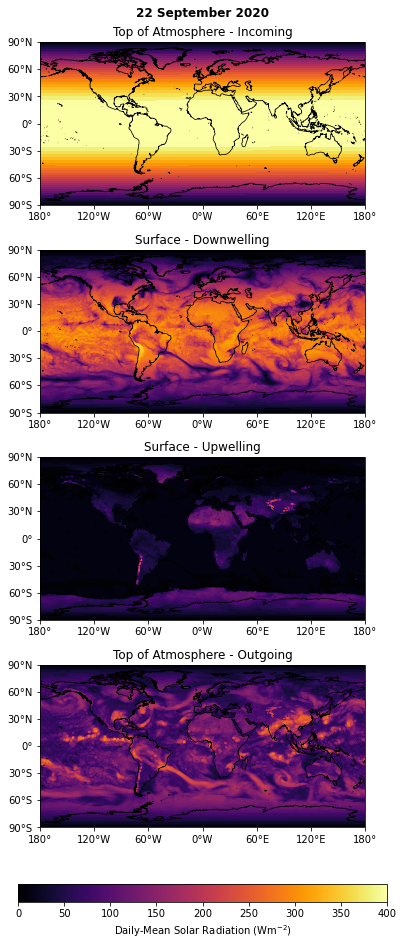

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(11,14), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

plot_geodata(ax1, lats, lons, tisr, 40, "inferno", "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd, 40, "inferno", "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru, 40, "inferno", "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr, 40, "inferno", "Top of Atmosphere - Outgoing")

fig.tight_layout(pad=2.0)
fig.suptitle("22 September 2020",
             y=0.999, fontweight="bold")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=400), 
                                      cmap="inferno"), 
                    ax=axs, orientation='horizontal', fraction=.1, shrink=0.49,
                    pad=0.06)
cbar.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar.set_label("Daily-Mean Solar Radiation ($\mathrm{W m^{-2}}$)")
#plt.savefig(os.path.join(data_dir, "RER1_Fig1.png"), 
#            dpi=300, bbox_inches="tight")

### Figure 2: Intrinsic Atmospheric Radiative Properties

1. Reflectivity
2. Absorptivity
3. Transmissivity

In [12]:
rom_analysis = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))

lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
reflectivity = rom_analysis.r.data
transmissivity = rom_analysis.t.data
absorptivity = rom_analysis.a.data

In [16]:
transmissivity.max()

0.81250435

In [17]:
transmissivity.min()

0.27663514

In [18]:
absorptivity.max()

0.31031913

In [19]:
absorptivity.min()

0.12836988

In [21]:
reflectivity.max()

0.47857818

In [22]:
reflectivity.min()

0.04126661

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(11,10), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

plot_geodata(ax1, lats, lons, reflectivity, 10, 1, "plasma", "Reflectivity")
plot_geodata(ax2, lats, lons, absorptivity, 10, 1, "plasma", "Absorptivity")
plot_geodata(ax3, lats, lons, transmissivity, 10, 1, "plasma", "Transmissivity")

fig.tight_layout(pad=2.0)
fig.suptitle("Intrinsic Atmospheric Radiative Properties",
             y=0.999, fontweight="bold")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), 
                                      cmap="plasma"), 
                    ax=axs, orientation='horizontal', fraction=.1, shrink=0.49,
                    pad=0.06)
cbar.ax.xaxis.set_ticks(np.arange(0, 1, 20), minor=True)
#cbar.set_label("Daily-Mean Solar Radiation ($\mathrm{W m^{-2}}$)")
plt.savefig(os.path.join(data_dir, "RER1_Fig2.png"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure 3: Reflectivity Optimization Map

1. Potential surface-reflected outgoing solar radiation
2. Actual surface-reflected outgoing solar radiation
3. Difference (gain)